# Importations et Configuration Initiale

Cette cellule importe les bibliothèques nécessaires (OpenCV, NumPy, Matplotlib, OS, Pytesseract) et configure le chemin vers l'exécutable de Tesseract si nécessaire.

**Points Clés :**
- Importation de `pytesseract`.


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pytesseract # Pour l'OCR Tesseract

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


# Fonctions Utilitaires

Cette cellule contient les fonctions d'aide utilisées dans le projet :
- `display_image`: Pour afficher les images avec Matplotlib.
- `order_points_centroid`: Pour ordonner les 4 coins d'un quadrilatère (utile pour le redressement de perspective).

In [17]:
# --- Fonction utilitaire pour afficher les images ---
def display_image(image, title="Image", cmap=None, ax=None, new_figure=True):
    if new_figure and ax is None : plt.figure(figsize=(6,6)); ax_internal=plt.gca()
    elif ax is not None: ax_internal = ax
    else: ax_internal = plt.gca()

    if cmap: ax_internal.imshow(image,cmap=cmap)
    else: ax_internal.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    ax_internal.set_title(title); ax_internal.axis('off')
    if new_figure and ax is None: plt.show()

# --- Fonction pour ordonner les points d'un rectangle ---
def order_points_centroid(pts):
    xSorted = pts[np.argsort(pts[:,0]),:]; leftMost=xSorted[:2,:]; rightMost=xSorted[2:,:]
    leftMost=leftMost[np.argsort(leftMost[:,1]),:]; (tl,bl)=leftMost
    rightMost=rightMost[np.argsort(rightMost[:,1]),:]; (tr,br)=rightMost
    return np.array([tl,tr,br,bl],dtype="float32")

# Détection et Recadrage de la Plaque d'Immatriculation (`detect_and_crop_plates`)

Cette fonction est responsable de la localisation de la plaque d'immatriculation dans l'image complète. Elle utilise une série d'étapes de traitement d'image traditionnelles :

1.  **Prétraitement :** Conversion en niveaux de gris, flou gaussien pour réduire le bruit.
2.  **Détection de Contours (Sobel) :** L'opérateur de Sobel est utilisé pour mettre en évidence les bords verticaux, caractéristiques des plaques.
3.  **Seuillage (Otsu) :** Conversion de l'image des bords en image binaire.
4.  **Opérations Morphologiques :**
    *   **Fermeture (`MORPH_CLOSE`) :** Avec un noyau rectangulaire large et plat pour connecter les segments de bords verticaux et former des régions candidates solides pour les plaques.
    *   **Érosion :** Pour éliminer les petits bruits ou les fines connexions.
    *   **Dilatation :** Pour rendre les régions candidates plus pleines.
5.  **Recherche de Contours :** Identification des formes distinctes dans l'image binaire traitée.
6.  **Filtrage des Contours :** Sélection des contours qui ressemblent géométriquement à des plaques (basé sur l'aire et le rapport largeur/hauteur du rectangle englobant d'aire minimale - `cv2.minAreaRect`).
7.  **Redressement de Perspective :** Pour chaque candidat valide, les 4 coins sont ordonnés et une transformation de perspective est appliquée pour obtenir une image recadrée et redressée de la plaque.

La fonction retourne une liste d'images BGR recadrées des plaques potentielles. La qualité de ces recadrages est essentielle pour la performance de Tesseract.

In [18]:
def detect_and_crop_plates(image, debug=False):
    # (Votre fonction detect_and_crop_plates existante et optimisée)
    detected_plates_crops = []
    original_height, original_width = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if debug: display_image(gray, "1. Grayscale for Detection", cmap='gray', new_figure=True)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    if debug: display_image(blurred, "2. Blurred", cmap='gray', new_figure=True)
    sobel_x = cv2.Sobel(blurred, cv2.CV_16S, 1, 0, ksize=3) 
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    if debug: display_image(abs_sobel_x, "3. Sobel X Edges", cmap='gray', new_figure=True)
    _, thresh = cv2.threshold(abs_sobel_x, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if debug: display_image(thresh, "4. Thresholded Edges", cmap='gray', new_figure=True)
    kernel_width = int(original_width * 0.05) 
    if kernel_width < 15: kernel_width = 15 
    if kernel_width % 2 == 0: kernel_width +=1 
    kernel_height = 3 
    if kernel_height % 2 == 0: kernel_height +=1
    if kernel_height < 1: kernel_height = 1
    morph_kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, kernel_height))
    if debug: print(f"Plate Detect: morph_kernel_close: ({kernel_width}, {kernel_height})")
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, morph_kernel_close, iterations=1) 
    if debug: display_image(closed, f"5. Morph Close ({kernel_width}x{kernel_height})", cmap='gray', new_figure=True)
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,2)) 
    eroded = cv2.erode(closed, erode_kernel, iterations=1) 
    if debug: display_image(eroded, "6. Eroded", cmap='gray', new_figure=True)
    dilate_kernel_w = max(5, kernel_width // 3) 
    if dilate_kernel_w % 2 == 0: dilate_kernel_w += 1
    dilate_kernel_h = 1 
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilate_kernel_w, dilate_kernel_h))
    dilated = cv2.dilate(eroded, dilate_kernel, iterations=1) 
    if debug: display_image(dilated, f"7. Dilated for Plate Contours", cmap='gray', new_figure=True)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_candidates = image.copy()
    for contour in contours:
        min_rect = cv2.minAreaRect(contour)
        (x_center, y_center), (width, height), angle = min_rect
        if width < height: width, height = height, width
        area = width * height
        min_plate_area = original_width * original_height * 0.001
        max_plate_area = original_width * original_height * 0.15   
        if not (min_plate_area < area < max_plate_area): continue
        aspect_ratio = width / float(height) if height > 0 else 0
        min_aspect_ratio = 1.5 
        max_aspect_ratio = 7.0 
        if not (min_aspect_ratio < aspect_ratio < max_aspect_ratio): continue
        box_float = cv2.boxPoints(min_rect)
        ordered_src_pts = order_points_centroid(box_float)
        cv2.drawContours(image_with_candidates, [box_float.astype(int)], 0, (0, 255, 0), 2)
        (tl, tr, br, bl) = ordered_src_pts
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        output_h = 100 
        if maxHeight > 10:
            aspect_ratio_detected = float(maxWidth) / maxHeight
            aspect_ratio_detected = max(1.5 * 0.8, min(aspect_ratio_detected, 7.0 * 1.2)) 
            output_w = int(output_h * aspect_ratio_detected)
        else: 
            output_w = int(output_h * 3.5)
        if output_w <=0: output_w = output_h * 2
        dst_pts = np.array([[0,0],[output_w-1,0],[output_w-1,output_h-1],[0,output_h-1]],dtype="float32")
        M = cv2.getPerspectiveTransform(ordered_src_pts, dst_pts)
        warped_plate_crop = cv2.warpPerspective(image, M, (output_w, output_h)) 
        detected_plates_crops.append(warped_plate_crop)
    if debug: display_image(image_with_candidates, "8. Candidate Plates", new_figure=True)
    return detected_plates_crops

# Prétraitement pour Tesseract et Reconnaissance des Chiffres (`preprocess_and_ocr_digits_with_tesseract`)

Cette fonction prend une image recadrée de plaque (BGR), la prétraite et utilise Tesseract OCR pour reconnaître **uniquement les chiffres**.

**Processus :**
1.  **Conversion en Niveaux de Gris et Flou :** L'image est convertie en niveaux de gris et un léger flou gaussien est appliqué.
2.  **Binarisation (Otsu Inversé) :** La méthode d'Otsu est utilisée pour binariser l'image. Le résultat est ensuite inversé (`cv2.bitwise_not`) pour obtenir du **texte blanc sur fond noir**, ce qui est une alternative que Tesseract peut gérer (bien que son attente par défaut soit souvent texte noir sur fond blanc).
3.  **Configurations Tesseract :** Plusieurs configurations de Tesseract sont essayées :
    *   `lang='eng'`: Indique à Tesseract d'utiliser son modèle pour la langue anglaise (qui inclut les chiffres).
    *   `-c tessedit_char_whitelist=0123456789`: **Crucial !** Ceci instruit Tesseract de ne considérer que les caractères de la liste blanche (les chiffres de 0 à 9).
    *   Différents modes de segmentation de page (`--psm`) sont testés (6, 7, 8, 13) car ils influencent la manière dont Tesseract interprète la structure du texte dans l'image.
4.  **Extraction et Filtrage du Texte :** Le texte brut de Tesseract est nettoyé pour ne conserver que les chiffres.
5.  **Sélection du Meilleur Résultat :** Pour chaque plaque candidate, le résultat Tesseract qui a produit la plus longue séquence de chiffres est conservé.

La fonction retourne le meilleur texte (chiffres uniquement), le nombre de chiffres reconnus, et l'image originale recadrée de la plaque.

In [19]:
def preprocess_and_ocr_digits_with_tesseract(plate_image_bgr, plate_idx=0, show_tesseract_prep_plots=False):
    print(f"\n--- Tesseract DIGIT OCR for Candidate Plate {plate_idx+1} ---")
    
    gray = cv2.cvtColor(plate_image_bgr, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3,3), 0) 
    _, thresh_otsu_direct_BW = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
    preprocessed_for_tesseract = cv2.bitwise_not(thresh_otsu_direct_BW) # White text on Black BG
    
    if show_tesseract_prep_plots:
        fig, axes = plt.subplots(1, 2, figsize=(10,5))
        display_image(gray, f"P{plate_idx+1} Gray for Tesseract", cmap='gray', ax=axes[0], new_figure=False)
        display_image(preprocessed_for_tesseract, f"P{plate_idx+1} OtsuInv for Tesseract", cmap='gray', ax=axes[1], new_figure=False)
        plt.show()
    
    configs_to_try_digits = [
        {'config_str': r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789', 'name': 'Digits_PSM6'},
        {'config_str': r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789', 'name': 'Digits_PSM7'},
        {'config_str': r'--oem 3 --psm 13 -c tessedit_char_whitelist=0123456789', 'name': 'Digits_PSM13'},
        {'config_str': r'--oem 3 --psm 8 -c tessedit_char_whitelist=0123456789', 'name': 'Digits_PSM8_SingleWord'},
    ]
    best_text_for_this_plate = ""; max_digit_count_for_this_plate = -1
    
    print(f"  Processing P{plate_idx+1} with Tesseract (Otsu Inverted input):")
    for tess_config_info in configs_to_try_digits:
        try:
            text = pytesseract.image_to_string(preprocessed_for_tesseract, 
                                               lang='eng', 
                                               config=tess_config_info['config_str'])
            text = text.strip() 
            filtered_text = ''.join(filter(str.isdigit, text))
            print(f"    Config: {tess_config_info['name']:<25} -> Raw: '{text[:30].replace(chr(10), ' ').replace(chr(12),'')}' -> Filtered: '{filtered_text}'") # Limit raw text print
            
            current_digit_count = len(filtered_text)
            if current_digit_count > max_digit_count_for_this_plate:
                max_digit_count_for_this_plate = current_digit_count
                best_text_for_this_plate = filtered_text
        except Exception as e:
            print(f"    Error with Tesseract ({tess_config_info['name']} on P{plate_idx+1}): {e}")
    
    print(f"  Best Tesseract DIGIT result for this plate candidate: '{best_text_for_this_plate}'")
    return best_text_for_this_plate, max_digit_count_for_this_plate, plate_image_bgr

# Exécution Principale et Traitement par Lots

Cette cellule orchestre l'ensemble du processus pour une liste d'images :
1.  Définit une liste d'images à traiter (`image_files_to_process`).
2.  Définit des indicateurs de débogage (`enable_plate_detection_debug_plots`, `enable_tesseract_prep_debug_plots`) pour contrôler l'affichage des étapes intermédiaires.
3.  Itère sur chaque image de la liste :
    *   Charge l'image.
    *   Appelle `detect_and_crop_plates` pour obtenir les candidats de plaques.
    *   Pour chaque plaque candidate recadrée, appelle `preprocess_and_ocr_digits_with_tesseract`.
    *   Suit la meilleure plaque candidate (celle qui donne le plus grand nombre de chiffres reconnus par Tesseract) pour l'image actuelle.
4.  Affiche l'image de la meilleure plaque choisie et le texte des chiffres reconnus pour chaque fichier image d'entrée.

**Important :**
- Assurez-vous que les chemins dans `image_files_to_process` sont corrects.
- La qualité de la détection de plaque par `detect_and_crop_plates` influence directement les résultats de l'OCR.

Tesseract version: 5.5.0.20241111


================ Traitement de l'image : Plates/plat16.jfif ================
Détecté 9 plaque(s) potentielle(s) dans plat16.jfif.

--- Tesseract DIGIT OCR for Candidate Plate 1 ---


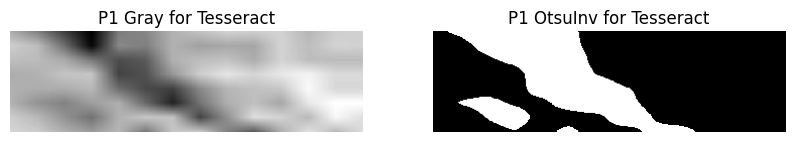

  Processing P1 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 2 ---


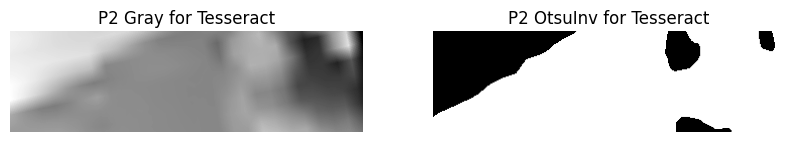

  Processing P2 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 3 ---


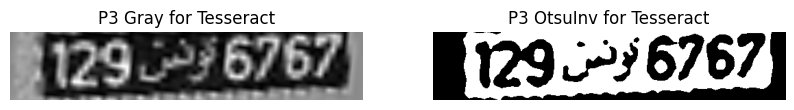

  Processing P3 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '81296767' -> Filtered: '81296767'
    Config: Digits_PSM7               -> Raw: '81296767' -> Filtered: '81296767'
    Config: Digits_PSM13              -> Raw: '81296767' -> Filtered: '81296767'
    Config: Digits_PSM8_SingleWord    -> Raw: '81296767' -> Filtered: '81296767'
  Best Tesseract DIGIT result for this plate candidate: '81296767'

--- Tesseract DIGIT OCR for Candidate Plate 4 ---


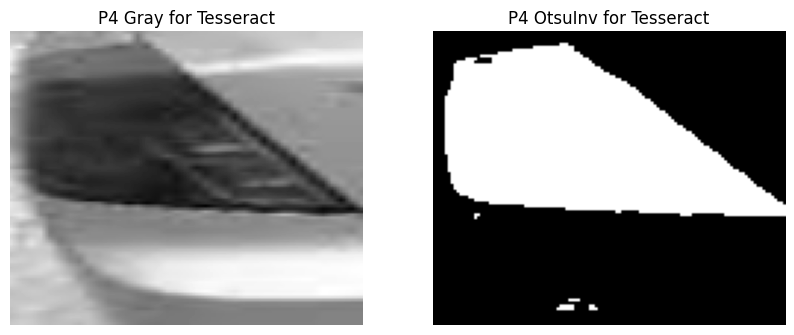

  Processing P4 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 5 ---


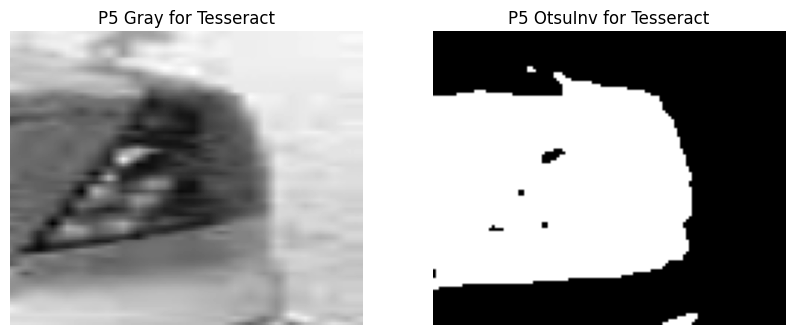

  Processing P5 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 6 ---


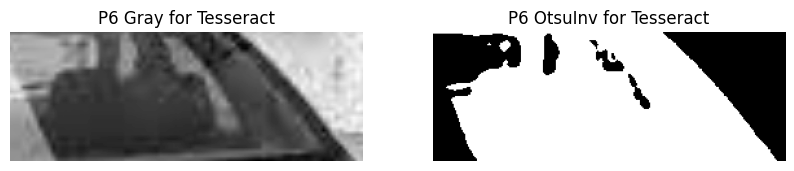

  Processing P6 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 7 ---


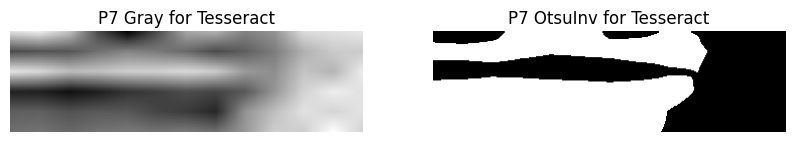

  Processing P7 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 8 ---


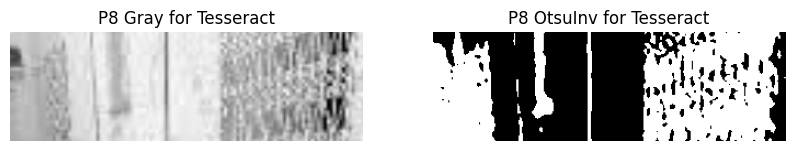

  Processing P8 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 9 ---


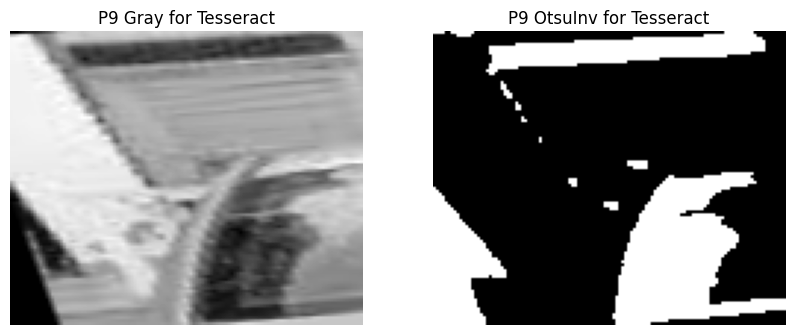

  Processing P9 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

---------------------------------------------
MEILLEUR RÉSULTAT FINAL pour plat16.jfif:


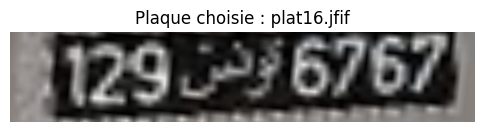

  Chiffres Reconnus : '81296767' (Nombre de chiffres : 8)
---------------------------------------------


================ Traitement de l'image : Plates/plat3.jfif ================
Détecté 2 plaque(s) potentielle(s) dans plat3.jfif.

--- Tesseract DIGIT OCR for Candidate Plate 1 ---


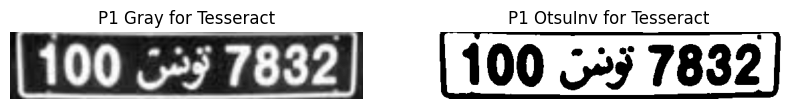

  Processing P1 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '10057832' -> Filtered: '10057832'
    Config: Digits_PSM7               -> Raw: '10057832' -> Filtered: '10057832'
    Config: Digits_PSM13              -> Raw: '100337832' -> Filtered: '100337832'
    Config: Digits_PSM8_SingleWord    -> Raw: '100337832' -> Filtered: '100337832'
  Best Tesseract DIGIT result for this plate candidate: '100337832'

--- Tesseract DIGIT OCR for Candidate Plate 2 ---


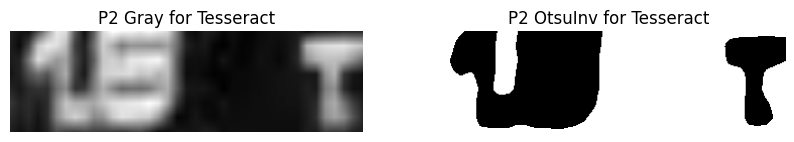

  Processing P2 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

---------------------------------------------
MEILLEUR RÉSULTAT FINAL pour plat3.jfif:


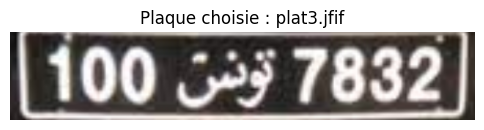

  Chiffres Reconnus : '100337832' (Nombre de chiffres : 9)
---------------------------------------------


================ Traitement de l'image : Plates/plat22.jfif ================
Détecté 7 plaque(s) potentielle(s) dans plat22.jfif.

--- Tesseract DIGIT OCR for Candidate Plate 1 ---


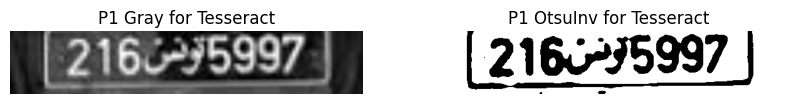

  Processing P1 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '21695997' -> Filtered: '21695997'
    Config: Digits_PSM7               -> Raw: '21695997' -> Filtered: '21695997'
    Config: Digits_PSM13              -> Raw: '216495997' -> Filtered: '216495997'
    Config: Digits_PSM8_SingleWord    -> Raw: '216495997' -> Filtered: '216495997'
  Best Tesseract DIGIT result for this plate candidate: '216495997'

--- Tesseract DIGIT OCR for Candidate Plate 2 ---


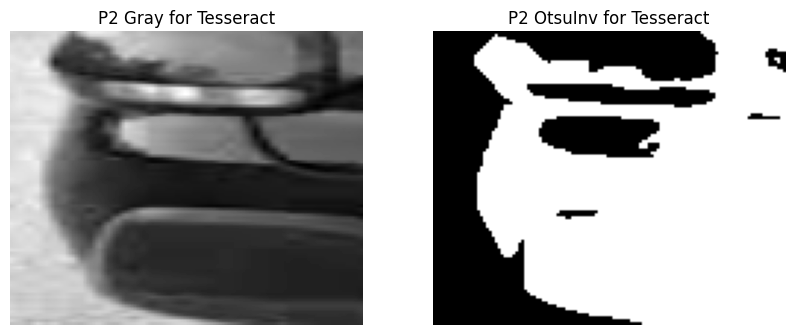

  Processing P2 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 3 ---


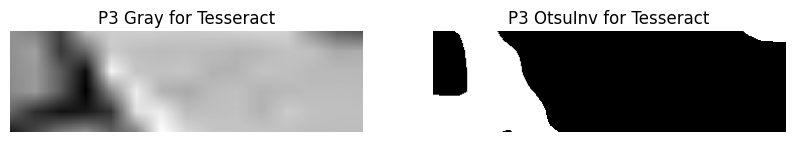

  Processing P3 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 4 ---


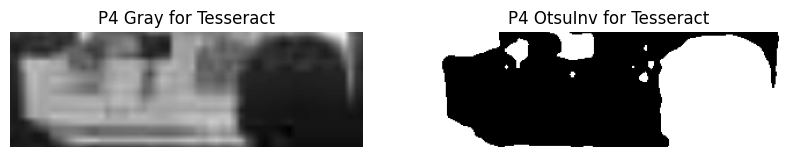

  Processing P4 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '1' -> Filtered: '1'
    Config: Digits_PSM7               -> Raw: '1' -> Filtered: '1'
    Config: Digits_PSM13              -> Raw: '1' -> Filtered: '1'
    Config: Digits_PSM8_SingleWord    -> Raw: '1' -> Filtered: '1'
  Best Tesseract DIGIT result for this plate candidate: '1'

--- Tesseract DIGIT OCR for Candidate Plate 5 ---


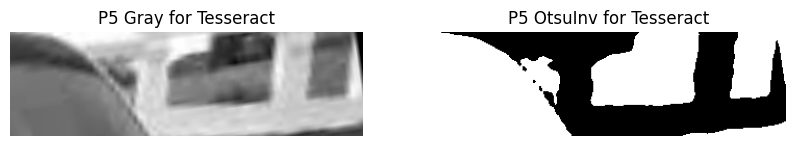

  Processing P5 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '5' -> Filtered: '5'
    Config: Digits_PSM8_SingleWord    -> Raw: '5' -> Filtered: '5'
  Best Tesseract DIGIT result for this plate candidate: '5'

--- Tesseract DIGIT OCR for Candidate Plate 6 ---


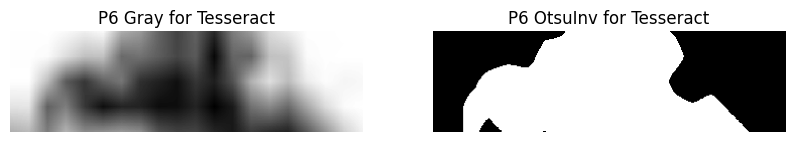

  Processing P6 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '60' -> Filtered: '60'
    Config: Digits_PSM7               -> Raw: '60' -> Filtered: '60'
    Config: Digits_PSM13              -> Raw: '60' -> Filtered: '60'
    Config: Digits_PSM8_SingleWord    -> Raw: '60' -> Filtered: '60'
  Best Tesseract DIGIT result for this plate candidate: '60'

--- Tesseract DIGIT OCR for Candidate Plate 7 ---


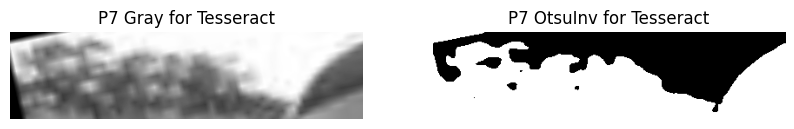

  Processing P7 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

---------------------------------------------
MEILLEUR RÉSULTAT FINAL pour plat22.jfif:


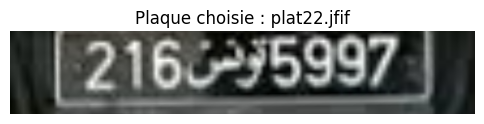

  Chiffres Reconnus : '216495997' (Nombre de chiffres : 9)
---------------------------------------------


================ Traitement de l'image : Plates/plat30.jfif ================
Détecté 6 plaque(s) potentielle(s) dans plat30.jfif.

--- Tesseract DIGIT OCR for Candidate Plate 1 ---


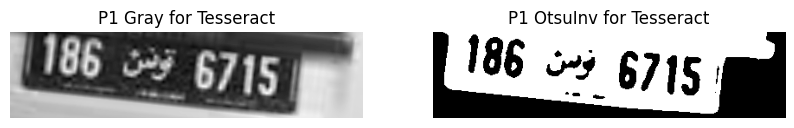

  Processing P1 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '186 596715' -> Filtered: '186596715'
    Config: Digits_PSM7               -> Raw: '186 596715' -> Filtered: '186596715'
    Config: Digits_PSM13              -> Raw: '186276715' -> Filtered: '186276715'
    Config: Digits_PSM8_SingleWord    -> Raw: '186276715' -> Filtered: '186276715'
  Best Tesseract DIGIT result for this plate candidate: '186596715'

--- Tesseract DIGIT OCR for Candidate Plate 2 ---


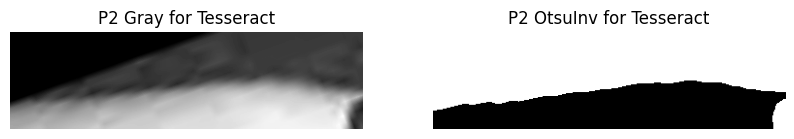

  Processing P2 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 3 ---


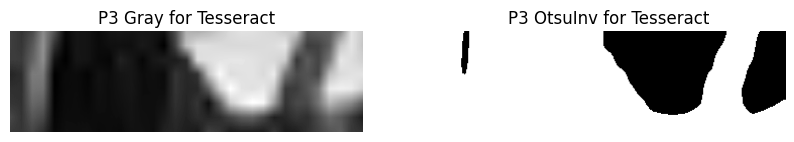

  Processing P3 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 4 ---


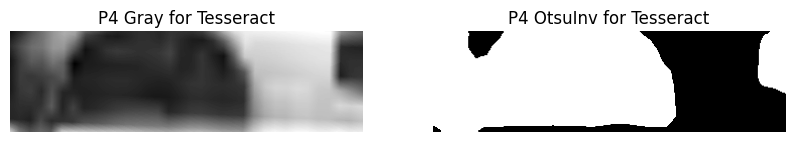

  Processing P4 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 5 ---


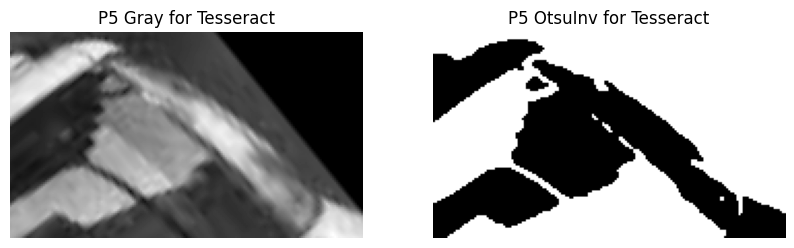

  Processing P5 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 6 ---


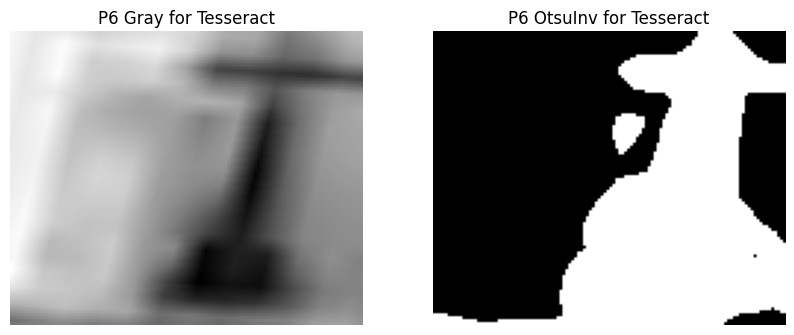

  Processing P6 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

---------------------------------------------
MEILLEUR RÉSULTAT FINAL pour plat30.jfif:


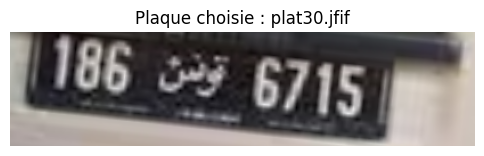

  Chiffres Reconnus : '186596715' (Nombre de chiffres : 9)
---------------------------------------------


================ Traitement de l'image : Plates/plat33.jfif ================
Détecté 7 plaque(s) potentielle(s) dans plat33.jfif.

--- Tesseract DIGIT OCR for Candidate Plate 1 ---


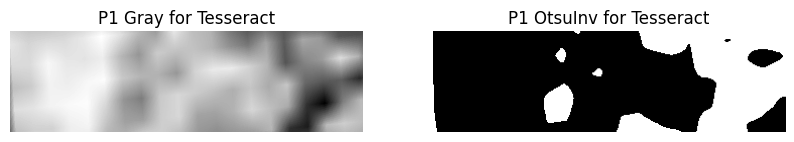

  Processing P1 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 2 ---


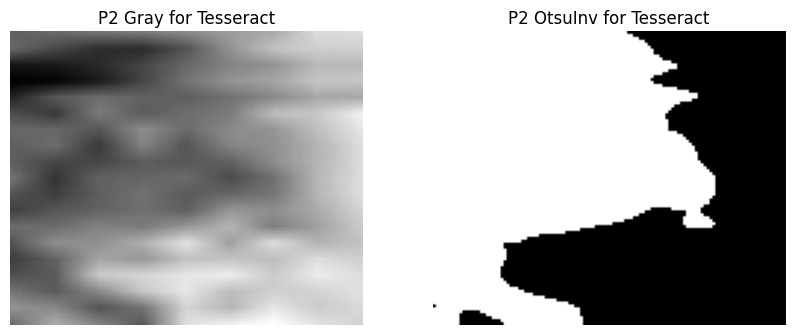

  Processing P2 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 3 ---


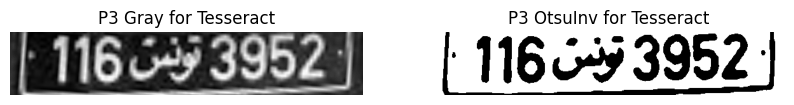

  Processing P3 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '116643952' -> Filtered: '116643952'
    Config: Digits_PSM7               -> Raw: '116643952' -> Filtered: '116643952'
    Config: Digits_PSM13              -> Raw: '1693952' -> Filtered: '1693952'
    Config: Digits_PSM8_SingleWord    -> Raw: '1693952' -> Filtered: '1693952'
  Best Tesseract DIGIT result for this plate candidate: '116643952'

--- Tesseract DIGIT OCR for Candidate Plate 4 ---


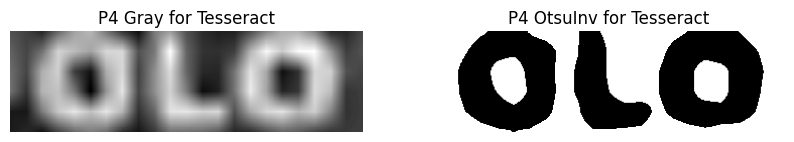

  Processing P4 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 5 ---


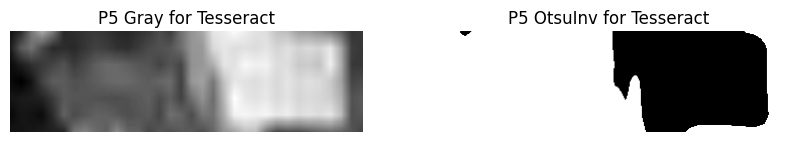

  Processing P5 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 6 ---


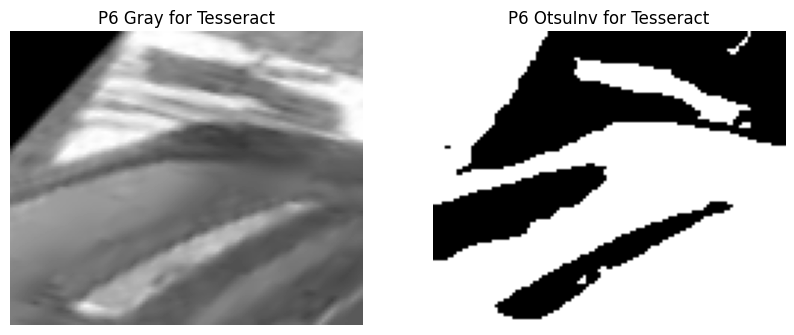

  Processing P6 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 7 ---


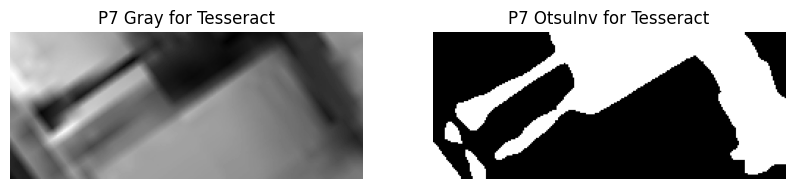

  Processing P7 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

---------------------------------------------
MEILLEUR RÉSULTAT FINAL pour plat33.jfif:


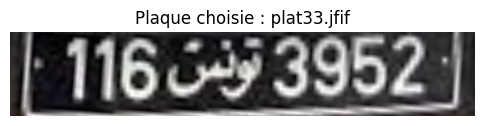

  Chiffres Reconnus : '116643952' (Nombre de chiffres : 9)
---------------------------------------------


================ Traitement de l'image : Plates/plat40.jfif ================
Détecté 7 plaque(s) potentielle(s) dans plat40.jfif.

--- Tesseract DIGIT OCR for Candidate Plate 1 ---


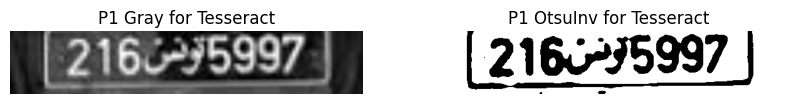

  Processing P1 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '21695997' -> Filtered: '21695997'
    Config: Digits_PSM7               -> Raw: '21695997' -> Filtered: '21695997'
    Config: Digits_PSM13              -> Raw: '216495997' -> Filtered: '216495997'
    Config: Digits_PSM8_SingleWord    -> Raw: '216495997' -> Filtered: '216495997'
  Best Tesseract DIGIT result for this plate candidate: '216495997'

--- Tesseract DIGIT OCR for Candidate Plate 2 ---


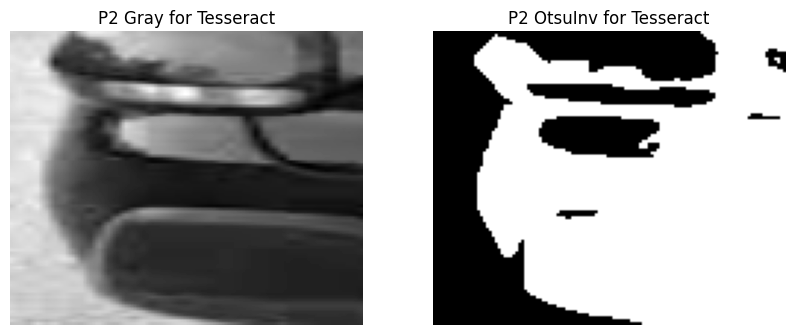

  Processing P2 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 3 ---


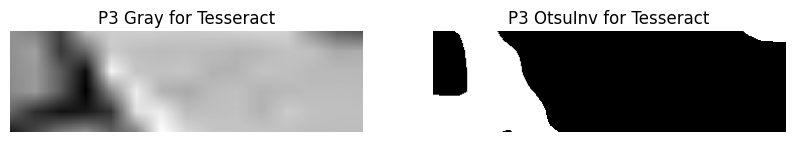

  Processing P3 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

--- Tesseract DIGIT OCR for Candidate Plate 4 ---


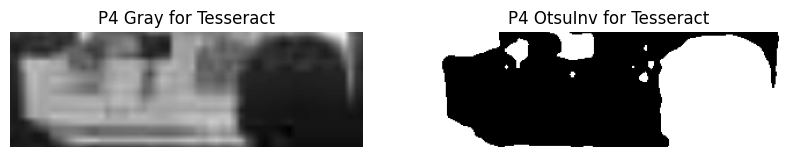

  Processing P4 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '1' -> Filtered: '1'
    Config: Digits_PSM7               -> Raw: '1' -> Filtered: '1'
    Config: Digits_PSM13              -> Raw: '1' -> Filtered: '1'
    Config: Digits_PSM8_SingleWord    -> Raw: '1' -> Filtered: '1'
  Best Tesseract DIGIT result for this plate candidate: '1'

--- Tesseract DIGIT OCR for Candidate Plate 5 ---


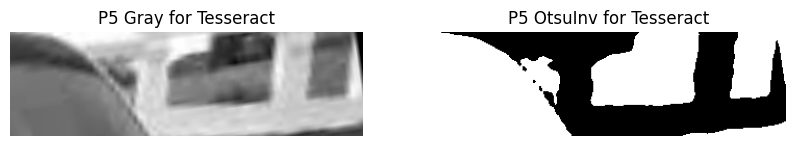

  Processing P5 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '5' -> Filtered: '5'
    Config: Digits_PSM8_SingleWord    -> Raw: '5' -> Filtered: '5'
  Best Tesseract DIGIT result for this plate candidate: '5'

--- Tesseract DIGIT OCR for Candidate Plate 6 ---


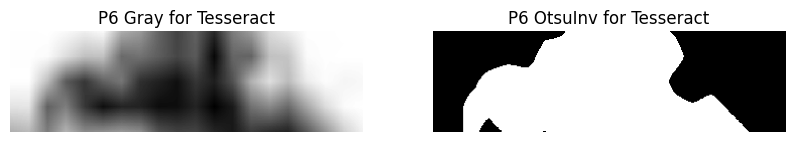

  Processing P6 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '60' -> Filtered: '60'
    Config: Digits_PSM7               -> Raw: '60' -> Filtered: '60'
    Config: Digits_PSM13              -> Raw: '60' -> Filtered: '60'
    Config: Digits_PSM8_SingleWord    -> Raw: '60' -> Filtered: '60'
  Best Tesseract DIGIT result for this plate candidate: '60'

--- Tesseract DIGIT OCR for Candidate Plate 7 ---


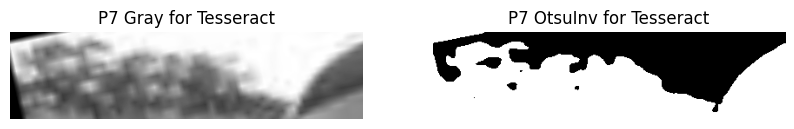

  Processing P7 with Tesseract (Otsu Inverted input):
    Config: Digits_PSM6               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM7               -> Raw: '' -> Filtered: ''
    Config: Digits_PSM13              -> Raw: '' -> Filtered: ''
    Config: Digits_PSM8_SingleWord    -> Raw: '' -> Filtered: ''
  Best Tesseract DIGIT result for this plate candidate: ''

---------------------------------------------
MEILLEUR RÉSULTAT FINAL pour plat40.jfif:


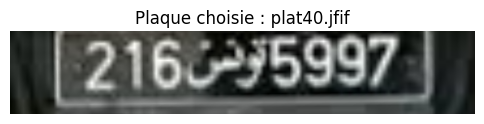

  Chiffres Reconnus : '216495997' (Nombre de chiffres : 9)
---------------------------------------------

Traitement par lots terminé.


In [20]:
if __name__ == "__main__":
    # Vérification optionnelle de Tesseract
    try:
        version = pytesseract.get_tesseract_version()
        print(f"Tesseract version: {version}")
    except Exception as e:
        print(f"Tesseract n'est peut-être pas correctement configuré ou trouvé: {e}")
        print("Si vous obtenez des erreurs Tesseract plus tard, veuillez vérifier votre installation et le chemin.")

    image_files_to_process = [
        "Plates/plat16.jfif",
        "Plates/plat3.jfif",
        "Plates/plat22.jfif",
        "Plates/plat30.jfif",
        "Plates/plat33.jfif",
        "Plates/plat40.jfif" 
    ]

    # Indicateurs de débogage globaux
    enable_plate_detection_debug_plots = False # True pour voir les étapes de détection de plaque
    enable_tesseract_prep_debug_plots = True # True pour voir les images prétraitées pour Tesseract

    for image_file_path in image_files_to_process:
        print(f"\n\n================ Traitement de l'image : {image_file_path} ================")
        full_image = cv2.imread(image_file_path)
        if full_image is None:
            print(f"Erreur : Impossible de lire l'image depuis {image_file_path}"); continue
        
        if enable_plate_detection_debug_plots:
            display_image(full_image, f"Originale : {os.path.basename(image_file_path)}", new_figure=True)

        cropped_plate_bgr_images = detect_and_crop_plates(full_image, debug=enable_plate_detection_debug_plots)
        print(f"Détecté {len(cropped_plate_bgr_images)} plaque(s) potentielle(s) dans {os.path.basename(image_file_path)}.")

        best_overall_text = ""
        highest_digit_count = -1 
        best_plate_image_crop = None

        if not cropped_plate_bgr_images:
            print(f"Aucun candidat de plaque détecté pour {os.path.basename(image_file_path)}.")
        else:
            for i, plate_bgr_crop in enumerate(cropped_plate_bgr_images):
                if plate_bgr_crop is None or plate_bgr_crop.size == 0:
                    print(f"Ignorer le recadrage de plaque vide pour le candidat {i}"); continue
                
                if enable_plate_detection_debug_plots : 
                    display_image(plate_bgr_crop, f"Plaque candidate {i+1} de {os.path.basename(image_file_path)}", new_figure=True)
                
                recognized_digits, digit_count, _ = preprocess_and_ocr_digits_with_tesseract(
                    plate_bgr_crop, 
                    plate_idx=i,
                    show_tesseract_prep_plots=enable_tesseract_prep_debug_plots
                )
                
                if digit_count > highest_digit_count:
                    highest_digit_count = digit_count
                    best_overall_text = recognized_digits
                    best_plate_image_crop = plate_bgr_crop
        
        print("\n" + "---"*15)
        if best_plate_image_crop is not None:
            print(f"MEILLEUR RÉSULTAT FINAL pour {os.path.basename(image_file_path)}:")
            display_image(best_plate_image_crop, f"Plaque choisie : {os.path.basename(image_file_path)}", new_figure=True)
            print(f"  Chiffres Reconnus : '{best_overall_text}' (Nombre de chiffres : {highest_digit_count})")
        else:
            print(f"Aucune plaque n'a pu être traitée avec succès pour les chiffres (ou aucune plaque détectée) dans {os.path.basename(image_file_path)}.")
        print("---"*15)
        
        # Gérer l'affichage des graphiques dans une boucle de notebook
        if enable_plate_detection_debug_plots or enable_tesseract_prep_debug_plots :
            if not plt.get_fignums(): # S'il n'y a pas de figures actives (par exemple si debug était False partout)
                pass
            else:
                plt.show() # Affiche toutes les figures accumulées pour cette image
        # Option pour fermer les figures pour éviter l'encombrement entre les images du lot
        # plt.close('all') # Décommentez si vous voulez fermer toutes les figures après chaque image du lot

    print("\nTraitement par lots terminé.")